# AMES Housing Data Analysis

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

# Importing the dataset

In [2]:
ds = pd.read_csv('Ames_Housing_Sales.csv')

In [3]:
ds.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,None,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,None,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,None,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,None,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,None,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [4]:
ds.shape

(1379, 80)

In [5]:
len(ds.columns)

80

In [6]:
X = ds.drop('SalePrice', axis = 1)
y = ds['SalePrice']

In [7]:
X.shape

(1379, 79)

In [8]:
y.shape

(1379,)

In [9]:
ds.dtypes.value_counts()

object     43
float64    21
int64      16
dtype: int64

# Taking care of missing data

In [10]:
# We observe no missing data
ds.isnull().sum().value_counts()

0    80
dtype: int64

# Encoding categorical data

In [11]:
# Performing one hot encoding using pd.get_dummies
# By default, this will convert any columns that of type object

X = pd.get_dummies(X, drop_first = True)

In [12]:
X.shape

(1379, 251)

# Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X)

In [14]:
# Confirm scaling

X2 = np.array(X_scaled)
manual_transform = (X2-X2.mean(axis = 0) / X2.std(axis = 0))
np.allclose(manual_transform, X2)

True

# Fitting the linear regression to the dataset

In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_scaled, y)
y_pred_lr = lr.predict(X_scaled)
pd.DataFrame(zip(X.columns, lr.coef_)).sort_values(by=1)

,0,1
147,GarageQual_TA,-24549.449822
144,GarageQual_Fa,-21939.456460
171,KitchenQual_TA,-11864.500818
170,KitchenQual_Gd,-11524.713090
145,GarageQual_Gd,-11149.884887
...,...,...
28,PoolArea,26321.276440
229,RoofMatl_WdShake,33553.116951
230,RoofMatl_WdShngl,41451.642204
228,RoofMatl_Tar&Grv,49062.795491


Looking just at the strength of the standardized coefficients GarageQual_TA, GarageQual_Fa, RoofMatl_Tar&Grv and RoofMatl_CompShg are all the 'most impactful'. Sklearn does not have built in statistical signifigance of each of these variables which would aid in making this claim stronger/weaker.

In [17]:
print('Sum of coefficients:', abs(lr.coef_).sum())
print('Total number of coefficients:', len(lr.coef_))
print('Number of coefficients not equal to 0:', (lr.coef_!=0).sum())
print('Linear Regression R2 score is:', r2_score(y, y_pred_lr))

Sum of coefficients: 1060631.6918750189
Total number of coefficients: 251
Number of coefficients not equal to 0: 251
Linear Regression R2 score is: 0.9307954458984128


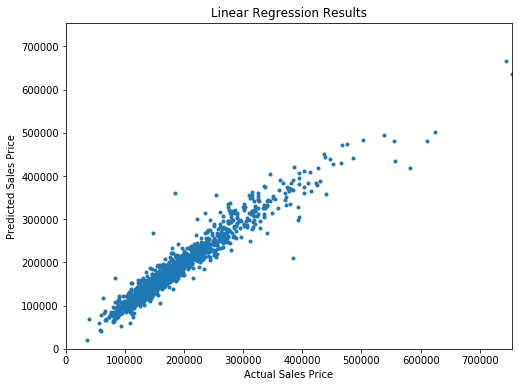

In [18]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y, y_pred_lr, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

# Adding the polynomial terms to the dataset

In [19]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 2, include_bias = False)
X_pf = pf.fit_transform(X)

In [20]:
sc_X = StandardScaler()
X_pf_scaled = sc_X.fit_transform(X_pf)

# LASSO

In [21]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1)
lasso.fit(X_pf_scaled, y)
y_pred = lasso.predict(X_pf_scaled)
pd.DataFrame(zip(X.columns, lasso.coef_)).sort_values(by=1)

,0,1
17,KitchenAbvGr,-10853.557275
15,GrLivArea,-7902.338000
3,BedroomAbvGr,-7450.047762
9,EnclosedPorch,-5873.875496
222,PoolQC_Gd,-4880.172726
...,...,...
12,GarageArea,7991.038279
8,BsmtUnfSF,11203.123351
4,BsmtFinSF1,12186.380613
1,2ndFlrSF,34465.765232


In [31]:
pd.DataFrame(lasso.coef_).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,31877.0,2.614958,432.020846,-10853.557275,0.0,-0.0,0.0,44808.255274


In [22]:
# From the below we observe that a large number of coefficients have been zeroed out.

print('Sum of coefficients:', abs(lasso.coef_).sum())
print('Total number of coefficients:', len(lasso.coef_))
print('Number of coefficients not equal to 0:', (lasso.coef_!=0).sum())
print('Lasso R2 for alpha = 1 is:', r2_score(y, y_pred))

Sum of coefficients: 1853098.2120321642
Total number of coefficients: 31877
Number of coefficients not equal to 0: 5198
Lasso R2 for alpha = 1 is: 0.999977381920978


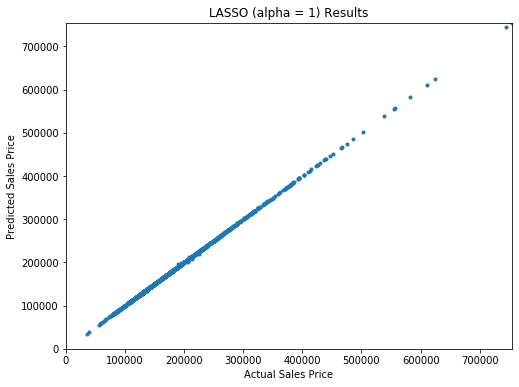

In [33]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y, y_pred, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO (alpha = 1) Results');

In [37]:
# Lasso for alpha = 0.01

lasso01 = Lasso(alpha = 0.01)
lasso01.fit(X_pf_scaled, y)
y_pred = lasso01.predict(X_pf_scaled)
pd.DataFrame(zip(X.columns, lasso01.coef_)).sort_values(by=1)

,0,1
17,KitchenAbvGr,-11671.168388
15,GrLivArea,-10096.826682
3,BedroomAbvGr,-9554.946462
31,TotalBsmtSF,-6980.748401
9,EnclosedPorch,-6956.716021
...,...,...
11,FullBath,8696.505723
8,BsmtUnfSF,11224.211950
4,BsmtFinSF1,12974.595184
1,2ndFlrSF,35814.384035


In [35]:
# From the below we observe that a much smaller number of coefficients have been 
# zeroed out in comparison to Lasso with alpha = 1

print('Sum of coefficients:', abs(lasso01.coef_).sum())
print('Total number of coefficients:', len(lasso01.coef_))
print('Number of coefficients not equal to 0:', (lasso01.coef_!=0).sum())
print('Lasso R2 for alpha = 0.01 is:', r2_score(y, y_pred))

Sum of coefficients: 4142793.33288558
Total number of coefficients: 31877
Number of coefficients not equal to 0: 19980
Lasso R2 for alpha = 0.01 is: 0.9999650095628029


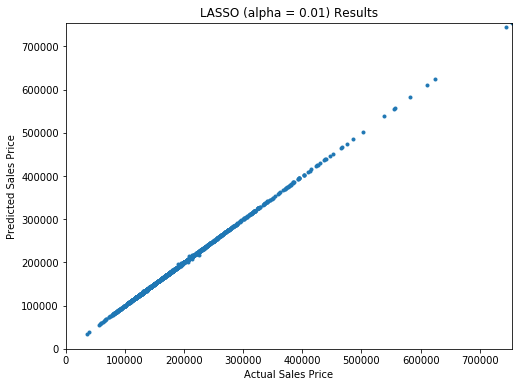

In [36]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y, y_pred, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO (alpha = 0.01) Results');

With more regularization (higher alpha) we will expect the penalty for higher weights to be greater and thus the coefficients to be pushed down. Thus a higher alpha means lower magnitude with more coefficients pushed down to 0.

# Splitting the dataset into the training set and test set

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size = 0.3, random_state = 0)

# Feature Scaling

In [39]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Calculating the $R^{2}$

In [40]:
from sklearn.metrics import r2_score

In [41]:
# Lasso (alpha = 1) Regression

lasso = Lasso(alpha = 1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print('Sum of coefficients:', abs(lasso.coef_).sum())
print('Total number of coefficients:', len(lasso.coef_))
print('Number of coefficients not equal to 0:', (lasso.coef_!=0).sum())
print('Lasso R2 for alpha = 1 is:', r2_score(y_test, y_pred_lasso))

Sum of coefficients: 1510404.3594291694
Total number of coefficients: 31877
Number of coefficients not equal to 0: 4348
Lasso R2 for alpha = 1 is: 0.5334352932323387


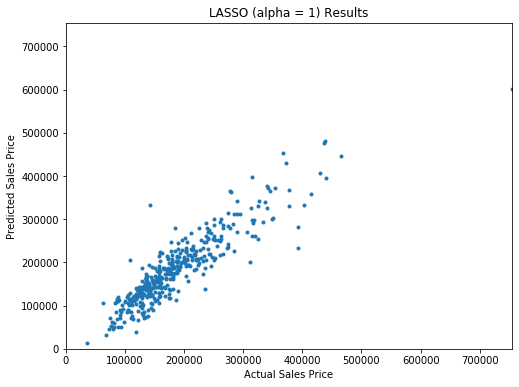

In [42]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred_lasso, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO (alpha = 1) Results');

In [43]:
# Lasso (alpha = 0.01) Regression

lasso01 = Lasso(alpha = 0.01)
lasso01.fit(X_train, y_train)
y_pred_lasso01 = lasso01.predict(X_test)

print('Sum of coefficients:', abs(lasso01.coef_).sum())
print('Total number of coefficients:', len(lasso01.coef_))
print('Number of coefficients not equal to 0:', (lasso01.coef_!=0).sum())
print('Lasso R2 for alpha = 0.01 is:', r2_score(y_test, y_pred_lasso01))

Sum of coefficients: 3525350.5082896915
Total number of coefficients: 31877
Number of coefficients not equal to 0: 18728
Lasso R2 for alpha = 0.01 is: 0.38713020386395114


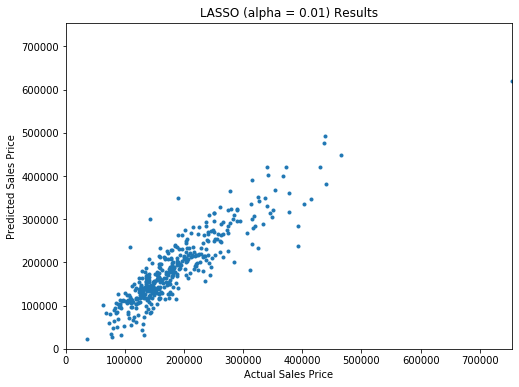

In [44]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred_lasso01, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO (alpha = 0.01) Results');

# Optimum alpha

In [45]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([160, 180, 200, 220, 240])
lassoCV = LassoCV(alphas=alphas2, max_iter=5e4, cv=4).fit(X_train, y_train)
print(lassoCV.alpha_)

240


In [46]:
# Lasso (alpha = 240) Regression

lasso240 = Lasso(alpha = 240)
lasso240.fit(X_train, y_train)
y_pred_lasso240 = lasso240.predict(X_test)

print('Sum of coefficients:', abs(lasso240.coef_).sum())
print('Total number of coefficients:', len(lasso240.coef_))
print('Number of coefficients not equal to 0:', (lasso240.coef_!=0).sum())
print('Lasso R2 for alpha = 240 is:', r2_score(y_test, y_pred_lasso240))

Sum of coefficients: 368406.0279454886
Total number of coefficients: 31877
Number of coefficients not equal to 0: 841
Lasso R2 for alpha = 240 is: 0.844101270644865


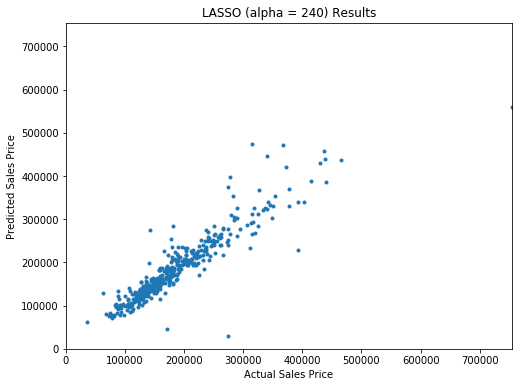

In [47]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred_lasso240, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO (alpha = 240) Results');

# L1 vs. L2 Regularization
As mentioned in the deck: `Lasso` and `Ridge` regression have the same syntax in SciKit Learn.

Now we're going to compare the results from Ridge vs. Lasso regression:

In [53]:
# Ridge with alpha = 0.01

from sklearn.linear_model import Ridge

rr = Ridge(alpha = 0.01)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

print('Sum of coefficients:', abs(rr.coef_).sum())
print('Total number of coefficients:', len(rr.coef_))
print('Number of coefficients not equal to 0:', (rr.coef_!=0).sum())
print('Ridge R2 for alpha = 0.01 is:', r2_score(y_test, y_pred))

Sum of coefficients: 1653692.182882933
Total number of coefficients: 31877
Number of coefficients not equal to 0: 19638
Ridge R2 for alpha = 0.01 is: 0.744802099960274


In [54]:
pd.DataFrame(zip(X.columns, rr.coef_)).sort_values(by=1)

,0,1
35,YrSold,-973.891972
222,PoolQC_Gd,-203.107150
170,KitchenQual_Gd,-130.812094
16,HalfBath,-123.168535
17,KitchenAbvGr,-112.560256
...,...,...
0,1stFlrSF,315.903990
27,OverallQual,343.637940
34,YearRemodAdd,344.800558
33,YearBuilt,351.253869


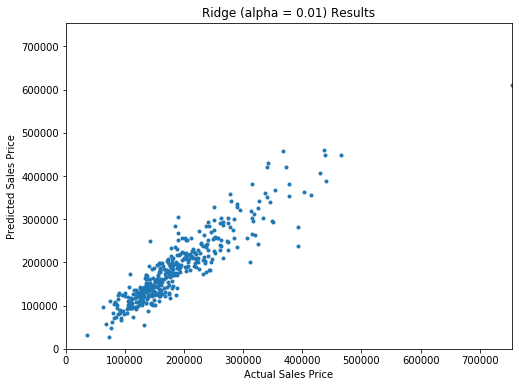

In [55]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='Ridge (alpha = 0.01) Results');

In [56]:
# Ridge with alpha = 1

from sklearn.linear_model import Ridge

rr = Ridge(alpha = 1)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

print('Sum of coefficients:', abs(rr.coef_).sum())
print('Total number of coefficients:', len(rr.coef_))
print('Number of coefficients not equal to 0:', (rr.coef_!=0).sum())
print('Ridge R2 for alpha = 1 is:', r2_score(y_test, y_pred))

Sum of coefficients: 1576204.7309504985
Total number of coefficients: 31877
Number of coefficients not equal to 0: 19638
Ridge R2 for alpha = 1 is: 0.7588244202226753


In [57]:
pd.DataFrame(zip(X.columns, rr.coef_)).sort_values(by=1)

,0,1
35,YrSold,-608.356685
222,PoolQC_Gd,-203.441379
170,KitchenQual_Gd,-129.765402
17,KitchenAbvGr,-113.108723
61,BsmtQual_Gd,-106.933447
...,...,...
27,OverallQual,295.577809
0,1stFlrSF,304.433071
33,YearBuilt,350.711995
15,GrLivArea,363.586329


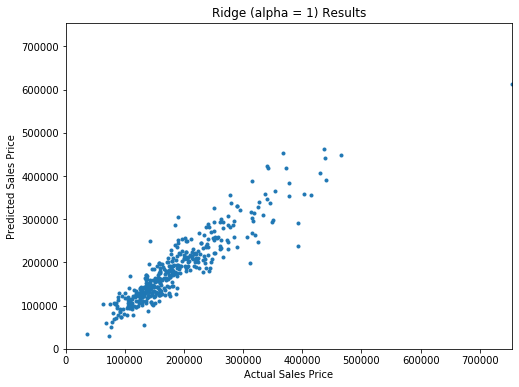

In [58]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='Ridge (alpha = 1) Results');

# Optimum alpha

In [59]:
from sklearn.linear_model import RidgeCV

alphas = [140, 160, 180]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
print(ridgeCV.alpha_)

180


In [60]:
# Ridge with alpha = 180

rr = Ridge(alpha = 180)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

print('Sum of coefficients:', abs(rr.coef_).sum())
print('Total number of coefficients:', len(rr.coef_))
print('Number of coefficients not equal to 0:', (rr.coef_!=0).sum())
print('Ridge R2 for alpha = 180 is:', r2_score(y_test, y_pred))

Sum of coefficients: 1049905.052453129
Total number of coefficients: 31877
Number of coefficients not equal to 0: 19638
Ridge R2 for alpha = 180 is: 0.8153834664576644


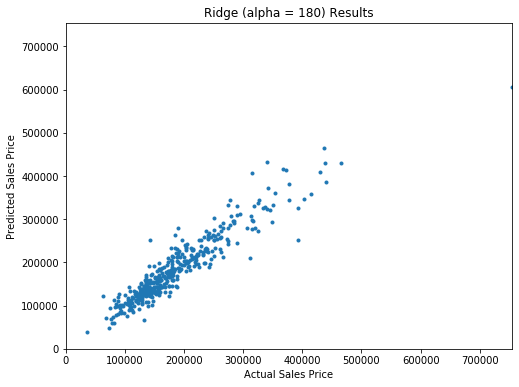

In [61]:
f = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
lim = (0, y.max())
ax.set(xlabel='Actual Sales Price', 
       ylabel='Predicted Sales Price', 
       xlim=lim,
       ylim=lim,
       title='Ridge (alpha = 180) Results');

## Conclusion

From our analysis we conclude that the most appropriate model for our dataset is the Ridge regression with a higher penalty parameter alpha. This is based on the better R2 score in comparison to LASSO. However, if feature selection is of priority, then LASSO with higher penalty parameter alpha should be used.

## Further Steps:

As an extension to the data analysis, we may have the below as new objectives:

- Perform Grid Search CV to achieve further parameter tuning.
- Produce models using alternative regression techniques such as:
    - Support Vector Machine (Linear, Polynomial, Gaussian RBF kernels)
    - Random Forest Regression
    - XG Boost
- Gather more data as time goes on for further model performance analysis.
- Using Principal Component Analysis for feature selection and explain the variance ratio
i.e. relevance of each feature for a simpler model.